In [1]:
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import re

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2, activity_l2
from keras.regularizers import l1, activity_l1

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import matthews_corrcoef



print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.


Required Libraries loaded.


In [2]:
# Import the data and explore the first few rows
# Import the data and explore the first few rows

inhibitor  = pd.read_csv("C:/EPC_Data/TREC_BROKEN/No_Mh_Tag/protonPumpInhibitors_no_mh.csv", sep=",", index_col='PMID')
header = inhibitor.columns.values
inhibitor.head()

,Label,TIABSMh
PMID,,
10146883,0,Omeprazole: a pharmacoeconomic evaluation of i...
10533944,0,Helicobacter treatment with quadruple therapy ...
10540041,0,Review article: nonsteroidal antiinflammatory ...
10540046,0,Helicobacter pylori treatment instead of maint...
10547167,0,Lack of effect of treatment for Helicobacter p...


In [3]:
#separate to negative and positive samples
# Select all rows with the index label "E"
negative_samples = inhibitor[inhibitor.Label == 0]#[lambda df: df.Label=='E', :]
positive_samples = inhibitor[inhibitor.Label == 1]#inhibitor.loc[lambda df: df.Label == 'I', :]

print ("Whole dataset: ", inhibitor.shape)
print ("Positive sample: ", positive_samples.shape)
print ("Negative samples: ", negative_samples.shape)

#divide to training and test sets
train_neg = negative_samples.sample(frac=0.7, random_state=2)
test_neg = negative_samples.drop(train_neg.index)

train_pos = positive_samples.sample(frac=0.7, random_state=2)
test_pos = positive_samples.drop(train_pos.index)

input_label = ([1] * train_pos.shape[0] + [0] * train_neg.shape[0] + [1] * test_pos.shape[0] + [0] * test_neg.shape[0])


print (train_neg.shape)
print (test_neg.shape)
print (train_pos.shape)
print (test_pos.shape)

('Whole dataset: ', (1314, 2))
('Positive sample: ', (54, 2))
('Negative samples: ', (1260, 2))
(882, 2)
(378, 2)
(38, 2)
(16, 2)


In [4]:
#merge the samples
#pmid = [train_pos["PMID"],train_neg["PMID"],test_pos["PMID"],test_neg["PMID"]]
#id = pd.concat(pmid)
frames = [train_pos["TIABSMh"],train_neg["TIABSMh"],test_pos["TIABSMh"],test_neg["TIABSMh"]]
dataset = pd.concat(frames)

In [5]:
# Import articles for string cleaning
sample_len = dataset.size
def clean_text(text, stem_words = False, remove_stopwords = True):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
              
    clean_corpus = texts.lower().split()
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]#
    
    return (" ".join(clean_corpus))

In [6]:
print ("Cleaning and parsing the document...\n")

cleaned_corpus = []

count = 0
for i in dataset.index:
    if ((count+1)%200 == 0):
        print ("Processing %d of %d \n" %(count+1, sample_len))
        
    cleaned_corpus.append(clean_text(dataset.ix[i], stem_words = False, remove_stopwords = True))
    count +=1
print ("Finished data loading and cleaning")

Cleaning and parsing the document...

Processing 200 of 1314 

Processing 400 of 1314 

Processing 600 of 1314 

Processing 800 of 1314 

Processing 1000 of 1314 

Processing 1200 of 1314 

Finished data loading and cleaning


In [7]:
len(cleaned_corpus)

1314

In [8]:
#decide on the total number of terms to retain
num_words = 10000
tok = Tokenizer(num_words)
train_size = train_pos.shape[0] + train_neg.shape[0]
print ("fitting ...")
tok.fit_on_texts(cleaned_corpus[:train_size])  #0 to 25000

print ("fitted to training data")

fitting ...
fitted to training data


In [9]:
words = []
for iter in range(num_words):
    words += [key for key,value in tok.word_index.items() if value==iter+1]

print "done"

done


In [10]:
words[:10]

['patients',
 'therapy',
 'use',
 'pylori',
 'h',
 'treatment',
 'mg',
 'omeprazole',
 'helicobacter',
 'ulcer']

In [11]:
#use the tokenizer to construct data matricies that look like the ones pre-supplied by keras
X_train = tok.texts_to_sequences(cleaned_corpus[:train_size])
X_test  = tok.texts_to_sequences(cleaned_corpus[train_size:])
y_train = input_label[:train_size]
y_test  = input_label[train_size:]

X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test  = sequence.pad_sequences(X_test,  maxlen=100)

print "done"

done


In [12]:
corpus = [X_train,X_test,y_train,y_test]
pickle.dump(corpus, open("inhibitor", "wb"))

In [13]:
corpus = pickle.load(open("inhibitor", "r"))

In [14]:
X_train,X_test,y_train,y_test = corpus

#### build models

In [15]:
#1. Basic RNN
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
#model.add(Dropout(0.25))

model.add(SimpleRNN(16, return_sequences=False))

model.add(Dense(128, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
#model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 100, 32)       320000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
simplernn_1 (SimpleRNN)          (None, 16)            784         embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 128)           2176        simplernn_1[0][0]                
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128)           0           dense_1[0][0]                    
___________________________________________________________________________________________

In [16]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, batch_size=32, verbose=0, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=32)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

Train on 920 samples, validate on 394 samples
Epoch 1/5
920/920 [==============================] - 1s - loss: 0.5826 - acc: 0.9500 - val_loss: 0.1853 - val_acc: 0.9594
Epoch 2/5
920/920 [==============================] - 11s - loss: 0.4091 - acc: 0.9587 - val_loss: 0.1860 - val_acc: 0.9594
Epoch 3/5
920/920 [==============================] - 1s - loss: 0.3286 - acc: 0.9587 - val_loss: 0.1824 - val_acc: 0.9594
Epoch 4/5
920/920 [==============================] - 1s - loss: 0.2439 - acc: 0.9587 - val_loss: 0.1833 - val_acc: 0.9594
Epoch 5/5
920/920 [==============================] - 1s - loss: 0.1746 - acc: 0.9685 - val_loss: 0.2088 - val_acc: 0.9594


C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:437: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


('Test score:', 0.20876092229246487)
('Test accuracy:', 0.95939086294416243)


C:\Users\CR107\Anaconda2\lib\site-packages\keras\backend\theano_backend.py:527: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


*** AUC for ROC = 0.616



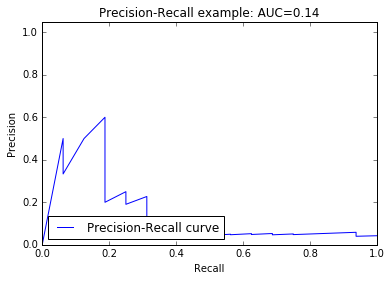

In [17]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [18]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(SimpleRNN(16, return_sequences=False))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 100, 32)       320000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100, 32)       0           embedding_2[0][0]                
____________________________________________________________________________________________________
simplernn_2 (SimpleRNN)          (None, 16)            784         dropout_1[0][0]                  
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 256)           4352        simplernn_2[0][0]                
___________________________________________________________________________________________

In [19]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=0,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, batch_size=32, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=32)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

394/394 [==============================] - 0s     
('Test score:', 0.14533334824866451)
('Test accuracy:', 0.95939086294416243)
*** AUC for ROC = 0.750



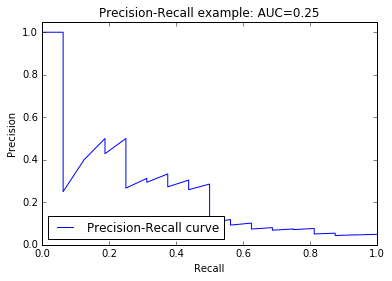

In [20]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [21]:

'''
    This example demonstrates the use of Convolution1D
    for text classification.
    Based on the examples from the Keras website  http://keras.io/
'''

# set parameters:
MAX_FEATURES= num_words
MAX_LEN = 100

batch_size = 128
embedding_dims = 16
nb_filter = 32
filter_length = 3
hidden_dims = 250
nb_epoch = 3

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(MAX_FEATURES, embedding_dims, input_length=MAX_LEN))
model.add(Dropout(0.25))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode="valid",
                        activation="relu",
                        subsample_length=1))
# we use standard max pooling (halving the output of the previous layer):
model.add(MaxPooling1D(pool_length=2))

# We flatten the output of the conv layer, so that we can add a vanilla dense layer:
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', class_mode="binary", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

(920, 'train sequences')
(394, 'test sequences')
Pad sequences (samples x time)
('X_train shape:', (920L, 100L))
('X_test shape:', (394L, 100L))
Build model...


C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:336: UserWarning: "class_mode" argument is deprecated, please remove it.
  warnings.warn('"class_mode" argument is deprecated, '
C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:396: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 920 samples, validate on 394 samples
Epoch 1/3
920/920 [==============================] - 2s - loss: 3.5477 - acc: 0.9217 - val_loss: 0.1959 - val_acc: 0.9594
Epoch 2/3
920/920 [==============================] - 4s - loss: 1.8316 - acc: 0.9587 - val_loss: 0.1711 - val_acc: 0.9594
Epoch 3/3
394/394 [==============================] - 0s     
('Test score:', 0.24028122077133449)
('Test accuracy:', 0.95939086294416243)
*** AUC for ROC = 0.764



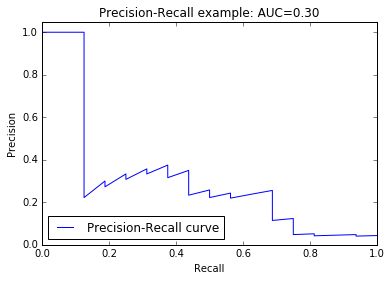

In [22]:
# Plot Precision-Recall curve
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
#plt.show()

In [23]:
#### LSTM
model = Sequential()

model.add(Embedding(num_words, 50))
model.add(Dropout(0.25))

model.add(LSTM(32))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print "fitting model ...."
model.fit(X_train, y_train, batch_size=1, nb_epoch=5, verbose=0,validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)


fitting model ....
394/394 [==============================] - 1s     
('Test score:', 0.22434381341684589)
('Test accuracy:', 0.95939086294416243)
*** AUC for ROC = 0.588



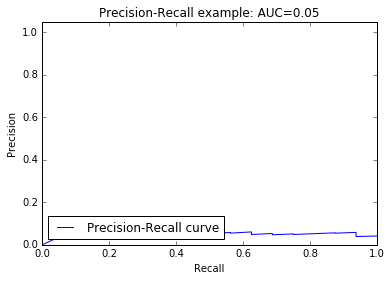

In [24]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [25]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(GRU(32,activation='relu'))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print "fitting model ...."
model.fit(X_train, y_train, batch_size=32, nb_epoch=20, verbose=0,validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

fitting model ....
384/394 [============================>.] - ETA: 0s('Test score:', 0.26063747806084547)
('Test accuracy:', 0.95939086294416243)
*** AUC for ROC = 0.797



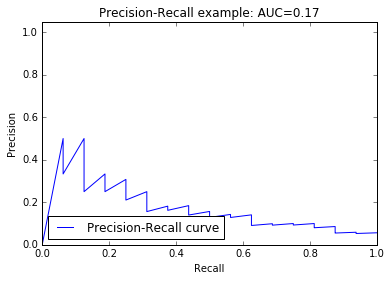

In [26]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")